In [1]:
import numpy as np
import gym
import os
from time import time
import time as tm
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [6]:
env.reset()
state, reward,done, _ = env.step(0)

In [7]:
theta = np.random.rand(4,2)

#### Analysis functions

In [3]:
def check_solve(R):
    l = 100
    for i in range(l,len(R)):
        if np.mean(R[i-l:i])>=195:
            print('Solved in {} steps.'.format(i-l))
            break
    print('Done!')

In [4]:
def opt(n_episodes,alpha,gamma):
    data = {'total_reward':[],'av_reward':[],'alpha':[],'gamma':[]}
    for i in alpha:
        for j in gamma:
            R = cp_play(n_episodes,i,j)
            data['av_reward']+=[np.mean(R)]
            data['total_reward']+=[np.sum(R)]
            data['alpha']+=[i]
            data['gamma']+=[j]
    return pd.DataFrame(data).sort_values(['total_reward'],ascending=False)

In [5]:
def plot_rewards(R):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.plot(range(len(R)),R);
    plt.title('Average reward: {:.2f}'.format(np.mean(R)))
    plt.subplot(1,2,2)
    plt.title('Total reward: {:.0f}'.format(np.sum(R)))
    plt.plot(range(len(R)),np.cumsum(R));

### REINFORCE

In [6]:
def softmax(state,theta):
    a = np.matmul(state,theta)
    return np.exp(a)/np.sum(np.exp(a))

def policy(softmax_probs):
    distw = sp.rv_discrete(name='distw',values=([0,1], softmax_probs))
    return distw.rvs()

def grads(action,softmax_probs):
    s = softmax_probs
    if action == 0:
        return np.array([1-s[0],-s[1]])[None,:]
    else:
        return np.array([-s[0],1-s[1]])[None,:]

In [7]:
def get_episode(theta):
    state = env.reset()
    episode = []
    while True:
        env.render()
        tm.sleep(0.01) # descomente para visualizar mais devagar
        s = softmax(state,theta)
        action = policy(s)
        next_state, reward, done, _ = env.step(action)
        episode.append((state,reward,action,s))
        state = next_state
        if reward >= 100: break
        if done: break
    return episode

In [12]:
def env_play(n_episodes,alpha,y):
    R = []
    episode_length = []
    theta = np.random.rand(env.observation_space.shape[0],env.action_space.n)
    for i in range(n_episodes):
        episode = get_episode(theta)
        states = [item[0] for item in episode]
        rewards = [item[1] for item in episode]
        actions = [item[2] for item in episode]
        softs = [item[3] for item in episode]
        R.append(sum(rewards))
        episode_length.append(len(episode))
        grad = [grads(i,s) for i,s in zip(actions,softs)]
        
        for t in range(len(grad)):
            theta += alpha*np.array(np.dot(states[t][None,:].T,grad[t])*sum([r*(y**j) for j,r in enumerate(rewards[t:])]))
        print('Step back, I am doing some math...')
        print("Episode: {} | Last reward: {:.2f} |  Mean reward: {:.1f}| Episode length: {}".format(i,R[-1],np.mean(R[-100:]),len(episode)))
        print("="*80)
        if np.mean(R[-100:]) > 195:
            print("Solved!!!!!!!!!!!!!!!!!!!!!!!!")
            print("Episode: {} | Mean reward: {:.1f}+-{:.1f}".format(i,np.mean(R[-100:]),np.std(R[-100:])))
            break
    return R

In [13]:
env_play(5,0.005,0.99)

Step back, I am doing some math...
Episode: 0 | Last reward: 14.00 |  Mean reward: 14.0| Episode length: 14
Step back, I am doing some math...
Episode: 1 | Last reward: 21.00 |  Mean reward: 17.5| Episode length: 21
Step back, I am doing some math...
Episode: 2 | Last reward: 32.00 |  Mean reward: 22.3| Episode length: 32
Step back, I am doing some math...
Episode: 3 | Last reward: 18.00 |  Mean reward: 21.2| Episode length: 18
Step back, I am doing some math...
Episode: 4 | Last reward: 18.00 |  Mean reward: 20.6| Episode length: 18


[14.0, 21.0, 32.0, 18.0, 18.0]

In [14]:
env.close()

CPU times: user 8.34 s, sys: 12.2 ms, total: 8.35 s
Wall time: 8.33 s


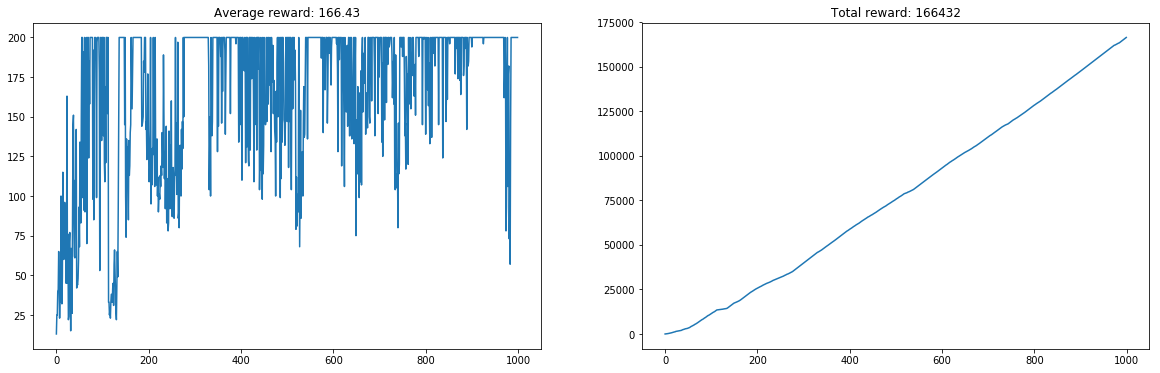

In [372]:
plot_rewards(R)

In [373]:
check_solve(R)

Solved in 829 steps.
Done!


---
#### Hyperparameters optimization

In [341]:
%%time
alpha = [0.01,0.008,0.006,0.004,0.002,0.001]
gamma = [0.99]
df = opt(1000,alpha,gamma)

CPU times: user 48.3 s, sys: 39.4 ms, total: 48.3 s
Wall time: 48.3 s


In [342]:
df

,total_reward,av_reward,alpha,gamma
2,178803.0,178.803,0.006,0.99
4,178048.0,178.048,0.002,0.99
5,165706.0,165.706,0.001,0.99
0,164319.0,164.319,0.010,0.99
1,154088.0,154.088,0.008,0.99
3,153023.0,153.023,0.004,0.99


In [26]:
def reward_results(n_tries,n_episodes,alpha,y):
    R_vec = []
    for i in range(n_tries):
        R = renv_play(n_episodes,alpha,y)
        R_vec.append(sum(R))
    print('|Av. R: {:.2f}| Std. R: {:.2f}| Max R: {:.2f}| Min R: {:.2f}|'.format(np.mean(R_vec),np.std(R_vec),max(R_vec),min(R_vec)))

In [ ]:
reward_results(n_tries,n_episodes,alpha,y)